#  Importing libraries 

In [26]:
import pandas as pd 
import numpy as np 
import os 

In [27]:
for dirname, _, filenames in os.walk('Garbage_Classification'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Garbage_Classification\one-indexed-files-notrash_test.txt
Garbage_Classification\one-indexed-files-notrash_train.txt
Garbage_Classification\one-indexed-files-notrash_val.txt
Garbage_Classification\one-indexed-files.txt
Garbage_Classification\zero-indexed-files.txt
Garbage_Classification\Garbage classification\cardboard\cardboard1.jpg
Garbage_Classification\Garbage classification\cardboard\cardboard10.jpg
Garbage_Classification\Garbage classification\cardboard\cardboard100.jpg
Garbage_Classification\Garbage classification\cardboard\cardboard101.jpg
Garbage_Classification\Garbage classification\cardboard\cardboard102.jpg
Garbage_Classification\Garbage classification\cardboard\cardboard103.jpg
Garbage_Classification\Garbage classification\cardboard\cardboard104.jpg
Garbage_Classification\Garbage classification\cardboard\cardboard105.jpg
Garbage_Classification\Garbage classification\cardboard\cardboard106.jpg
Garbage_Classification\Garbage classification\cardboard\cardboard107.jpg
Garbage_

In [28]:
!pip install imutils 

In [29]:
# reading and processing data 
import cv2
import urllib 
import itertools 
import seaborn as sns 
import os, random, glob
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.utils import shuffle
from urllib.request import urlopen 

# ignore warnings 
import warnings 
warnings.filterwarnings('ignore')

# model evaluation 
from sklearn.metrics import confusion_matrix, classification_report 

# modeling 

import tensorflow as tf 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

#  Reading the dataset 

In [30]:
dir_path = 'Garbage_Classification/Garbage classification'

In [32]:
target_size = (200, 200)
waste_labels = {'cardboard':0, 'glass':1, 'metal':2, 'paper':3, 'plastic':4, 'trash':5}

In [33]:
def load_dataset(path):
    """ 
  It reads the images in the directory and creates their labels.

  Parameters:

  path: Refers to the directory where the images are located.
  Return:
   x: It stores the matrix information of the images.
  labels: A list that holds the class information of each image.
  """
    x = []
    labels = []
    # It lists and sorts the images in the specified path
    image_paths = sorted(list(paths.list_images(path)))
   
    for image_path in image_paths :
        # The images in the specified path are read using the OpenCV library
        img = cv2.imread(image_path)
        # resize the read image 
        img = cv2.resize(img, target_size)
        # the resized images are added to the x list
        x.append(img)
         # When each path is split by '/', the second-to-last element of the resulting list represents the label
        label = image_path.split(os.path.sep)[-2]
        
        # The label is created by retrieving the corresponding value for the given key from the `waste_labels`

        # dictionary, which contains the numerical representations of the captured labels
        labels.append(waste_labels[label])
        # the dataset is shuffled randomly
    x, labels = shuffle(x, labels, random_state = 42)
    print(f'X size : {np.array(x).shape}')
    print(f'Number of label classes {np.unique(labels)}, Number of observation in the dataset : {len(labels)}')
    
    return x, labels 


In [34]:
x, labels = load_dataset(dir_path)

X size : (2527, 200, 200, 3)
Number of label classes [0 1 2 3 4 5], Number of observation in the dataset : 2527


In [35]:
input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[0], 3)
print(input_shape)

(200, 200, 3)


In [36]:
np.array(list(list(waste_labels.keys())))

array(['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
      dtype='<U9')

# Sample from dataset

In [37]:
def visualize_img(image_batch, label_batch,n):
    """  Parameters:



  image_batch: Storing the matrix information of the images



  label_batch: A list that stores the class information of the image

    """
    plt.figure(figsize=(15,65))
    j = 0
    for n in range(100+n):
        ax = plt.subplot(20,5,j+1)
        j +=1
        plt.imshow(image_batch[n])
        plt.title(np.array(list(waste_labels.keys())) [to_categorical(labels, num_classes=6)[n]==1][0].title())

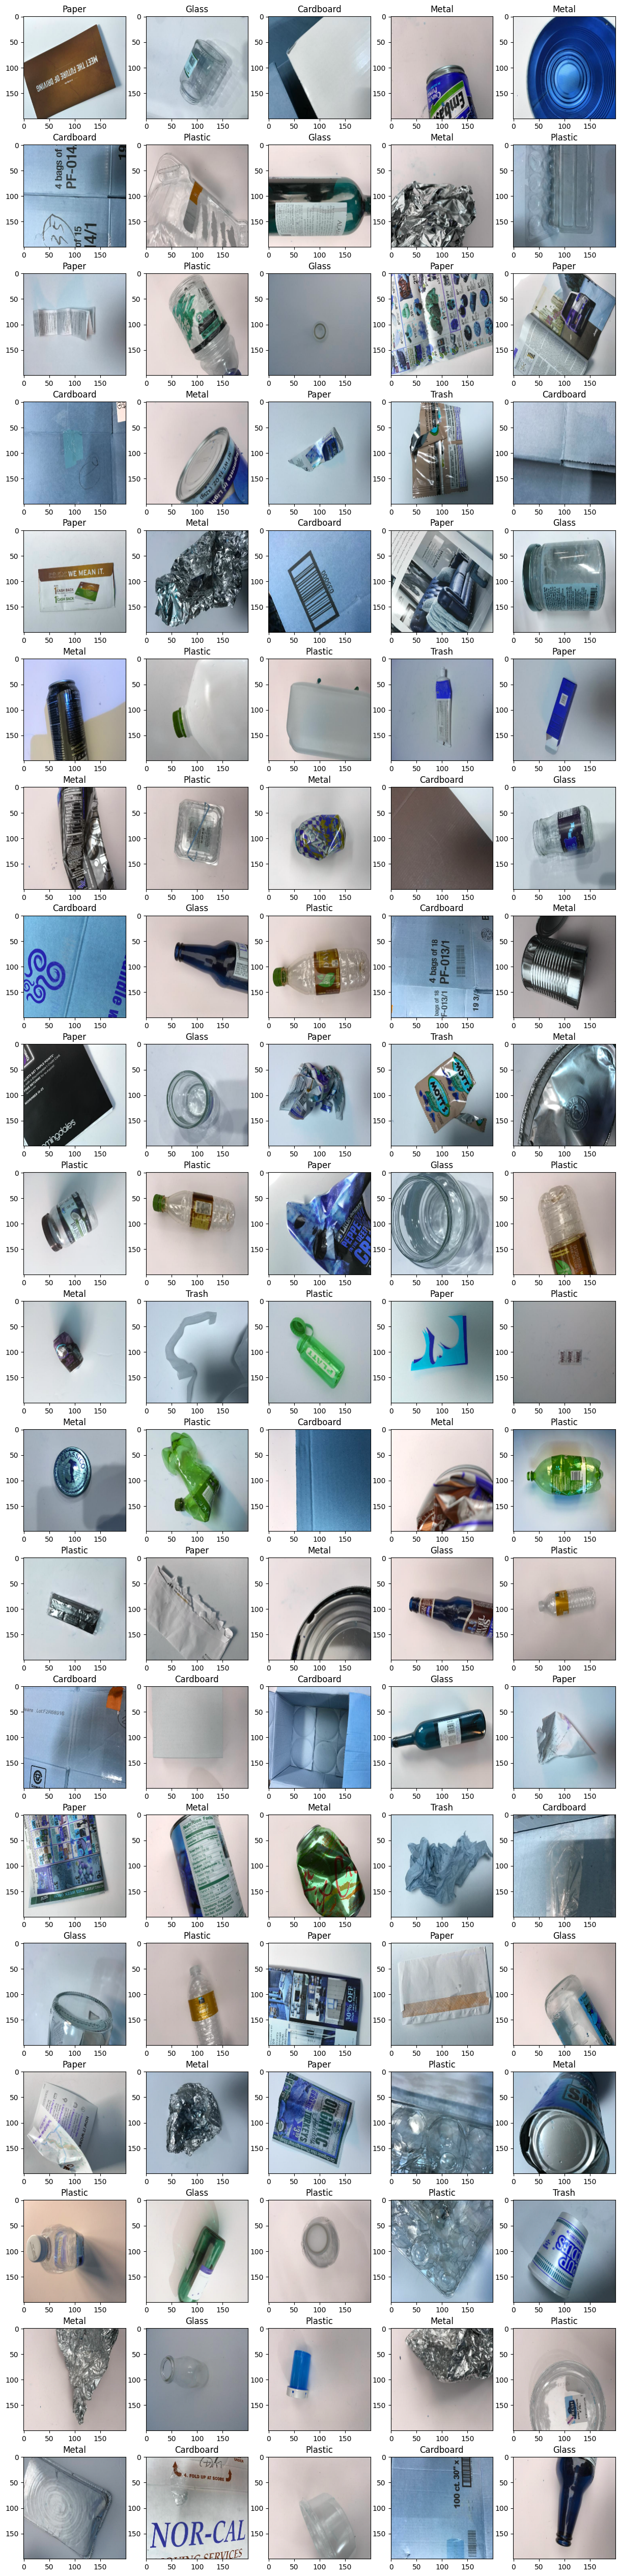

In [38]:
visualize_img(x, labels,0)

# Data augmentation 
- this step means generate more data using the exsting data 

In [41]:
train = ImageDataGenerator(horizontal_flip=True,
                           rotation_range=20,
                          vertical_flip=True,
                          validation_split=0.1,
                          rescale=1./255,
                          shear_range=0.1,
                          zoom_range=0.1,
                          width_shift_range=0.1,
                          height_shift_range=0.1)
test = ImageDataGenerator(rescale = 1./255,
                         validation_split=0.1)

In [42]:
train_generator = train.flow_from_directory(directory=dir_path,
                                            
                                            target_size = (target_size),
                                            
                                            class_mode = 'sparse',
                                            
                                            subset = 'training')

test_generator = test.flow_from_directory(directory=dir_path,

                                            target_size = (target_size),

                                            batch_size = 251,

                                            class_mode = 'sparse',

                                            subset = 'validation')

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


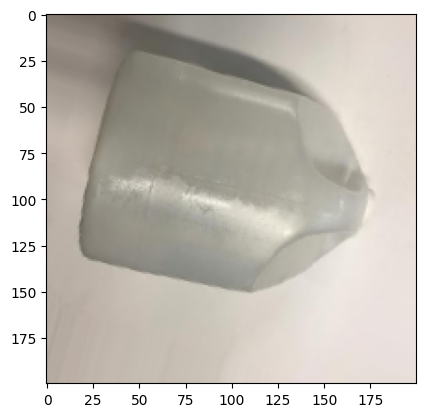

In [43]:
(x, y) = next(train_generator)
plt.imshow(x[0])

# Modeling
- Create a CNN model 

In [48]:
model = Sequential([
    # Layer 1
    Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', 
           activation='relu', input_shape=input_shape),  # Output: (28, 28, 64)
    MaxPooling2D(pool_size=(2, 2)),                     # Output: (14, 14, 64)
    
    # Layer 2
    Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', activation='relu'),  
    MaxPooling2D(pool_size=(2, 2)),                                                          
    
    # Layer 3
    Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),  
    MaxPooling2D(pool_size=(2, 2)),
    
    
    # Layer 4
    Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),  
    MaxPooling2D(pool_size=(2, 2)),
    MaxPooling2D(pool_size=(2, 2)),
    
    # layer 5 
    Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),  
    MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten and Fully Connected Layers
    Flatten(),                                                                             
    Dense(units=128, activation='relu'),
    Dropout(0.25),
    Dense(units=256, activation='relu'),
    Dropout(0.5),
    Dense(units=256, activation='relu'),
    Dropout(0.25),
    Dense(units=128, activation='relu'),
    Dropout(0.10),
    Dense(units=6, activation='softmax'), 
])

In [49]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)                   │ (None, 200, 200, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 100, 100, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 48, 48, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 22, 22, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 3, 3, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 556,742 (2.12 MB)

 Trainable params: 556,742 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

# Compile the model 

In [50]:
callbacks = [EarlyStopping(monitor='val_loss',

                           patience=50,

                           verbose=1,

                           mode="min"),



             ModelCheckpoint(filepath='Model_1.keras',

                             monitor='val_loss',
                             mode='min',

                             save_best_only=True,

                             save_weights_only=False,

                             verbose=1)]

In [20]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [25]:
history = model.fit(train_generator, epochs = 20, steps_per_epoch=2276//32, validation_steps=251//32,
          callbacks = callbacks, validation_data = test_generator )

Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8298 - loss: 0.4962
Epoch 1: val_loss did not improve from 0.64428
71/71 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.8298 - loss: 0.4960 - val_accuracy: 0.7410 - val_loss: 0.9425
Epoch 2/20
 1/71 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - accuracy: 0.7812 - loss: 0.4652
Epoch 2: val_loss did not improve from 0.64428
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.7812 - loss: 0.4652 - val_accuracy: 0.7530 - val_loss: 0.9550
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8422 - loss: 0.4557
Epoch 3: val_loss did not improve from 0.64428
71/71 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.8422 - loss: 0.4560 - val_accuracy: 0.6972 - val_loss: 0.8517
Epoch 4/20
 1/71 ━━━━━━━━━━━━━━━━━━━━ 3:49 3s/step - accuracy: 0.7188 - loss: 0.7570
Epoch 4: val_loss did not improve from 0.64428
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.7188 - loss: 0.7570 - val_accuracy: 0.7052 - val_loss: 0.8539
Epoch 5/20


In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('mymodel.keras')


In [ ]:
# Compile the model again if needed
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training
model.fit(new_train_data, new_train_labels, epochs=10, validation_data=(new_val_data, new_val_labels))
model.save('mymodel_updated.keras')

# Testing

# Evaluation 

# Deployment